# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
%matplotlib inline
import datetime
import json
import urllib
import os
import glob

---
## Step 0: Load The Data

In [2]:
#because python has two img formats: unit8 and float. It is better to stick to one format early on. 
def normalize_0to1(X):
    if X.dtype==np.uint8:
        X_tmp = X.astype('float32')/255
    else:
        raise RuntimeError("X is not of type uint8 but " + str(X.dtype))
    return X_tmp

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = normalize_0to1(train['features']), train['labels']
X_valid, y_valid = normalize_0to1(valid['features']), valid['labels']
X_test, y_test = normalize_0to1(test['features']), test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
signnames = pd.read_csv("signnames.csv").set_index("ClassId")["SignName"]
signnames_rev = signnames.reset_index().set_index("SignName")

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

#### Potting few examples from the dataset

In [6]:
def plot_image(ax, img, title=""):
    if img.shape[-1] == 1:
        ax.imshow(img[:,:,0], cmap='Greys_r')
    else:
        ax.imshow(img[:,:,:])            
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

In [7]:
def plot_samples(X, y, cols=4, rows=4, size=5, sample=True):
    num_examples = rows * cols
    num_examples = min(X.shape[0], num_examples)
    f, ax = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
    ax = ax.ravel()
    for i in range(num_examples):
        if sample:
            n = np.random.randint(X.shape[0])
        else:
            n = i
        if y is None:            
            title = ""
        else:
            title = signnames[y[n]]
        plot_image(ax[i], X[n,:,:,:], title)

In [8]:
def plot_samples_all_classes(X, y, y_labels=signnames, samples_per_class=4, size=5, sample=True):
    ys = pd.Series(y)
    classes = np.unique(y)
    
    rows = classes.shape[0]
    cols = samples_per_class
    num_examples = rows * cols    
    f, ax = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
    f.tight_layout()
    ax = ax.ravel()
    
    ax_cnt = 0
    for c in classes:
        c_idx = ys[ys==c].index.values
        title = y_labels[c]
        if sample:
            np.random.shuffle(c_idx)
        for i in c_idx[:cols]:            
            plot_image(ax[ax_cnt], X[i,:,:,:], title)
            ax_cnt += 1

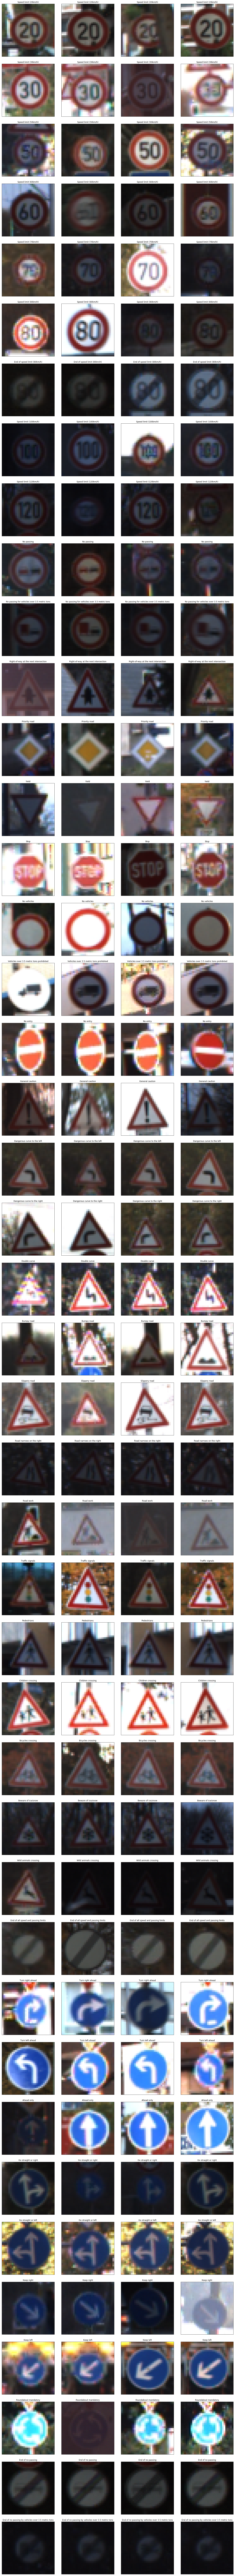

In [9]:
plot_samples_all_classes(X_valid, y_valid)

In [10]:
def plot_all_classes(X, y, samples_per_class=1, cols=10, size=1, sample=True):
    ys = pd.Series(y)
    classes = np.sort(np.unique(y))
    
    all_classes = []
    for c in classes:
        c_idx = ys[ys==c].index.values
        if sample:
            np.random.shuffle(c_idx)
        for i in c_idx[:samples_per_class]:            
            all_classes.append(X[i,:,:,:])
    
    n = len(all_classes)
    rows = np.ceil(n/cols).astype(int)
    img_shape = all_classes[0].shape
    final_img = np.ones((rows*img_shape[0],cols*img_shape[1],img_shape[2]))
    for r in range(rows):
        for c in range(cols):
            if (r*cols+c)>= n:
                break
            final_img[r*img_shape[0]:(r+1)*img_shape[1]
                      ,c*img_shape[0]:(c+1)*img_shape[1],:] = all_classes[(r*cols+c)]

    figsize= (np.ceil(cols*size).astype(int), np.ceil(rows*size).astype(int))
    plt.figure(figsize=figsize)
    plt.imshow(final_img)
    plt.xticks([])
    plt.yticks([])

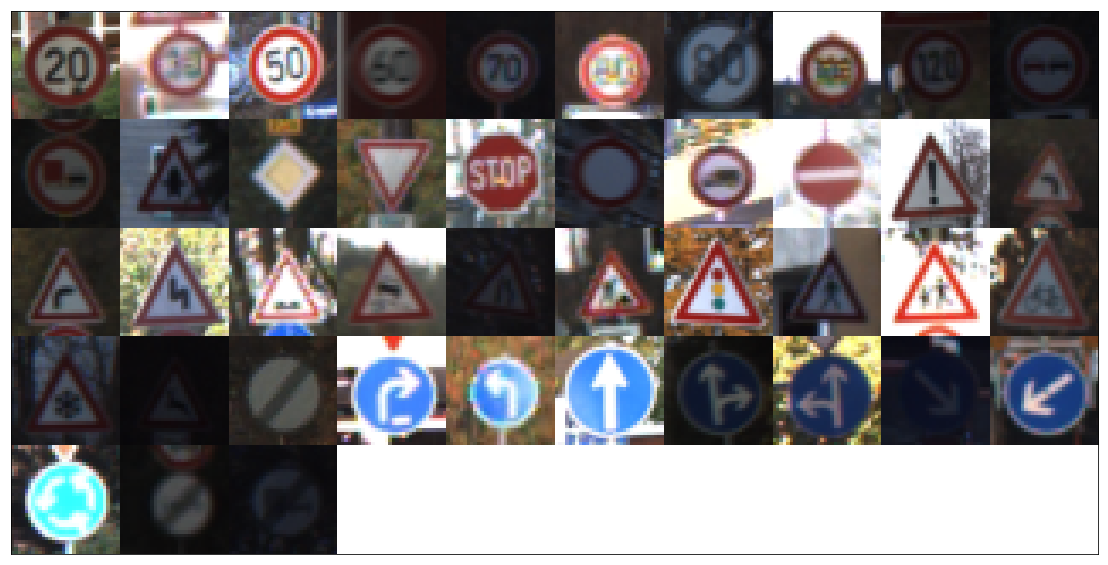

In [11]:
plot_all_classes(X_valid, y_valid, samples_per_class=1, size=2)

### Looking at label distribution

In [12]:
def plot_label_dist(y, names):
    s = pd.Series(y_train)
    df = pd.DataFrame({
        'counts':s.value_counts()
        ,'percentage':s.value_counts(normalize=True).round(4)*100
    }).join(signnames).set_index("SignName")
    print("Total #lables: {}".format(len(df)))
    df.plot.bar(x=df.index, y="percentage", figsize=(16,9))
    plt.ylabel("Percentage of total #train examples")
    plt.legend([])

Total #lables: 43


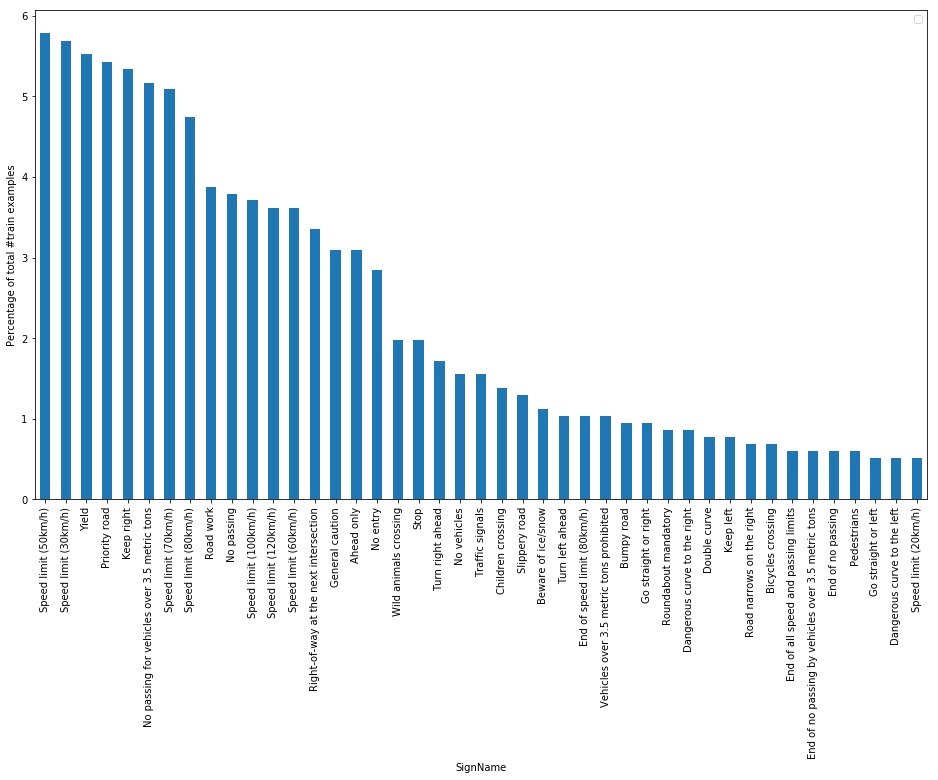

In [13]:
plot_label_dist(y_train, signnames)

### Using TSNE to visualize the data

In [14]:
#https://indico.io/blog/visualizing-with-t-sne/
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne():
    # convert image data to float64 matrix. float64 is need for bh_sne
    x_data = grayscale(X_valid).reshape((X_valid.shape[0], -1)).astype(np.float64)

    # For speed of computation, only run on a subset
    n = 4000
    x_data,y_data = shuffle(x_data,y_valid)
    x_data = x_data[:n]                      
    y_data = y_valid[:n]

    model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    vis_data = model.fit_transform(x_data)

    # plot the result
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]

    plt.figure(figsize=(16,9))
    plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 43))
    plt.colorbar(ticks=range(43))
    plt.clim(-0.5, 42.5)
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [15]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


### Grayscale

In [16]:
def grayscale(X):
    X_gray = np.zeros(X.shape[:-1])
    for i in range(X.shape[0]):
        X_gray[i,:,:] = cv2.cvtColor(X[i,:,:,:], cv2.COLOR_RGB2GRAY)
    return X_gray.reshape((X_gray.shape[0],X_gray.shape[1],X_gray.shape[2],1))

In [17]:
X_valid_gray = grayscale(X_valid)  

In [18]:
def plot_side_by_side(X, X_transformed, y, cols=2, rows=2, size=5, sample=True):
    cols = cols * 2 #we need to plot orignal and transformed images
    num_examples = min(rows * cols, 2*X.shape[0])
    f, ax = plt.subplots(rows, cols, figsize=(cols*size,rows*size))
    ax = ax.ravel()
    for i in range(0, num_examples, 2):        
        if sample:
            n = np.random.randint(X.shape[0])            
        else:
            n = i//2
        plot_image(ax[i], X[n,:,:,:], signnames[y[n]])
        plot_image(ax[i+1], X_transformed[n,:,:,:], signnames[y[n]])

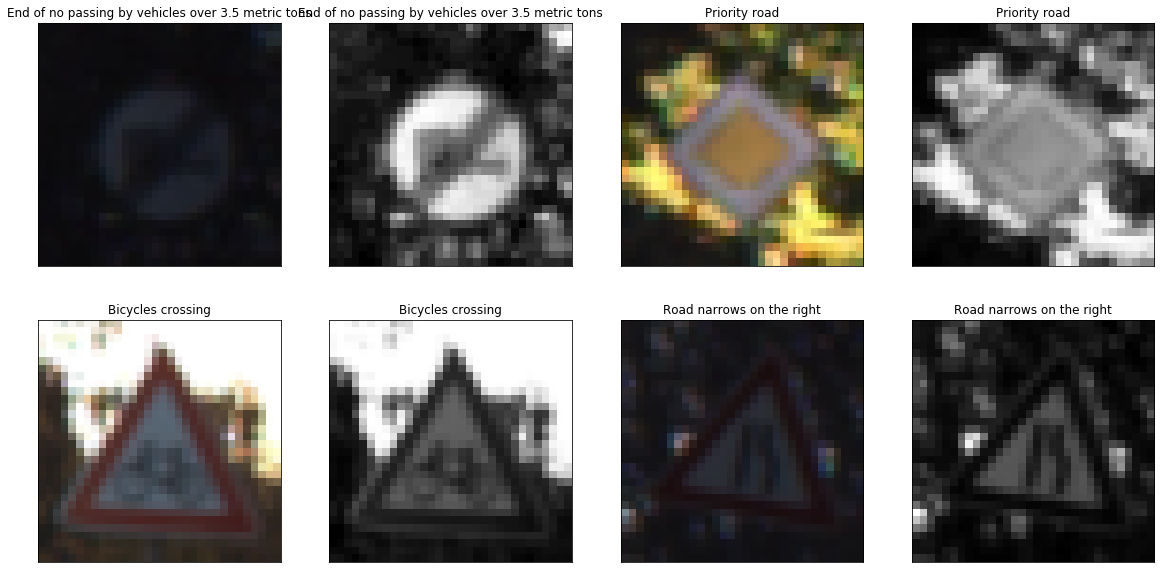

In [19]:
plot_side_by_side(X_valid, X_valid_gray, y_valid)

### Adding random noise

In [20]:
def add_noise(X, noise_ratio = 0.07):
    X_rnd = X + np.random.random(X.shape)*noise_ratio
    X_rnd[X_rnd>1] = 1
    return X_rnd

In [21]:
X_valid_noise = add_noise(X_valid) 

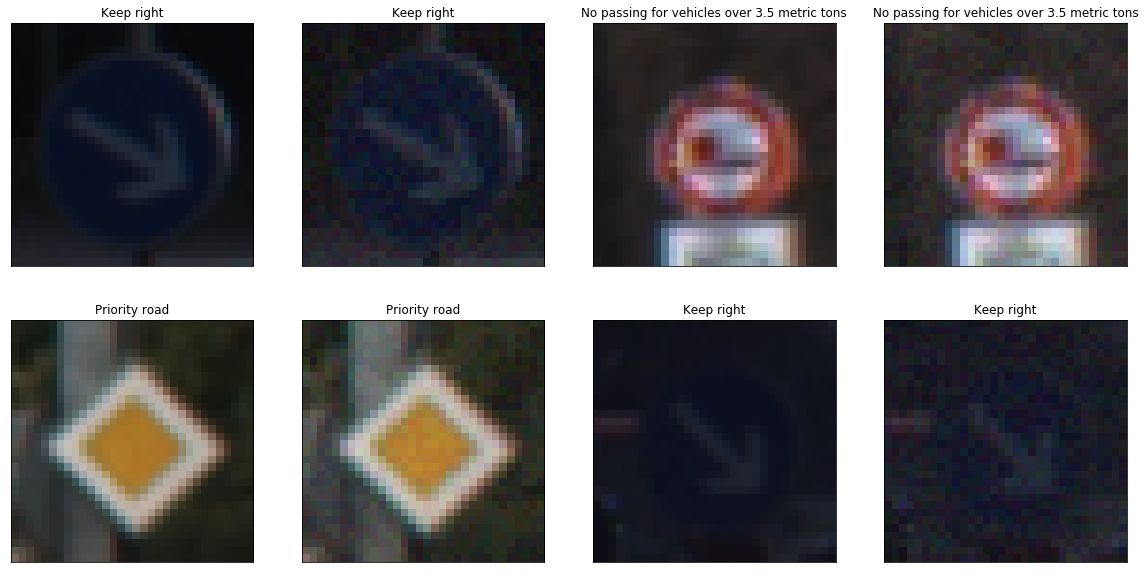

In [22]:
plot_side_by_side(X_valid, X_valid_noise, y_valid)

### Shifting images

In [23]:
def shift(X, shit_pct=0.4):
    X_shift = np.zeros(X.shape)    
    rows,cols = X.shape[1:3]
    shift_pts_x = np.random.randint(int(cols*shit_pct))*(-1)**np.random.randint(1,3)
    shift_pts_y = np.random.randint(int(cols*shit_pct))*(-1)**np.random.randint(1,3)
    M = np.float32([[1,0,shift_pts_x],[0,1,shift_pts_y]])
    
    if X_shift.shape[-1]==1:
        for i in range(X.shape[0]):
            X_shift[i,...] = cv2.warpAffine(X[i,...],M,(cols,rows)).reshape(rows,cols,1)
    else:
        for i in range(X.shape[0]):
            X_shift[i,...] = cv2.warpAffine(X[i,...],M,(cols,rows))
    return X_shift

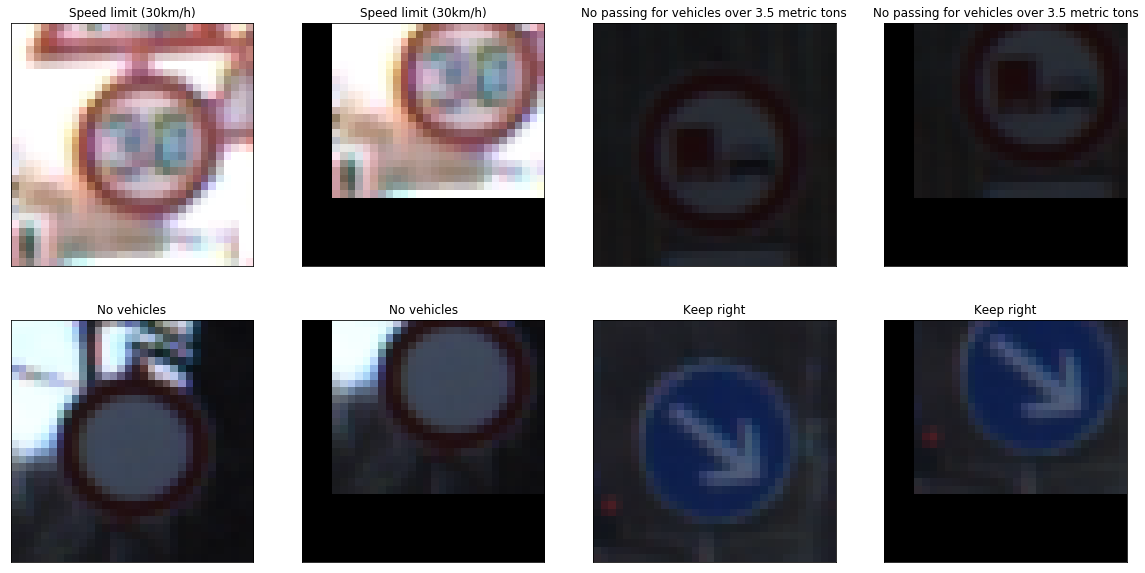

In [24]:
idx = np.random.randint(X_valid.shape[0], size=10)
plot_side_by_side(X_valid[idx,...], shift(X_valid[idx,...]), y_valid[idx,...], sample=False)

### Adding blur

In [25]:
def blur(X):
    X_blur = np.zeros(X.shape)
    blur_size = (np.random.randint(2,4),np.random.randint(2,4))
    if X_blur.shape[-1]==1: #grayscale needs special treatment
        for i in range(X.shape[0]):
            X_blur[i,...] = cv2.blur(X[i,...], blur_size).reshape(X_blur.shape[1],X_blur.shape[2],1)
    else:        
        for i in range(X.shape[0]):
            X_blur[i,...] = cv2.blur(X[i,...], blur_size)
    return X_blur

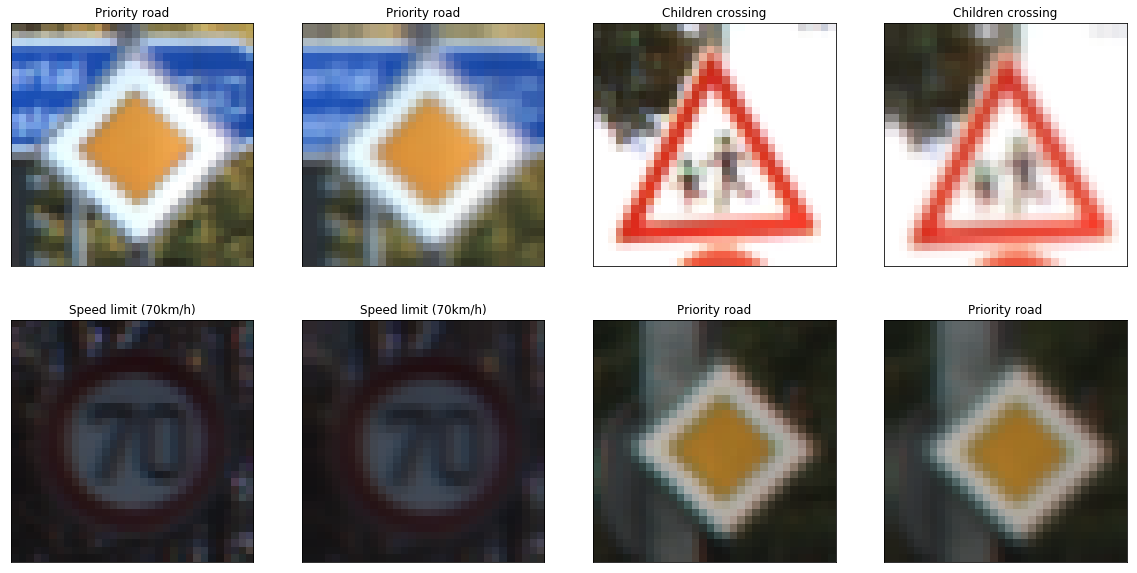

In [26]:
idx = np.random.randint(X_valid.shape[0], size=10)
plot_side_by_side(X_valid[idx,...], blur(X_valid[idx,...]), y_valid[idx,...], sample=False)

### Rotating the image

In [27]:
def rotate(X, rnd_rotation=True, degree=None, range=[-30,30]):
    X_rotated = np.zeros(X.shape)
    n = X_rotated.shape[0]
    rows,cols = X.shape[1:3]
    if rnd_rotation:
        deg = range[0] + (np.random.rand(n)*(range[1]-range[0]))
    else:
        deg = np.repeat(degree, n)
    if X_rotated.shape[-1]==1: #grayscale needs special treatment
        for i,d in enumerate(deg):        
            M = cv2.getRotationMatrix2D((cols/2,rows/2),d,1)
            X_rotated[i,...] = cv2.warpAffine(X[i,...],M,(cols,rows)).reshape(rows,cols,1)
    else:
        for i,d in enumerate(deg):        
            M = cv2.getRotationMatrix2D((cols/2,rows/2),d,1)
            X_rotated[i,...] = cv2.warpAffine(X[i,...],M,(cols,rows))
    return X_rotated

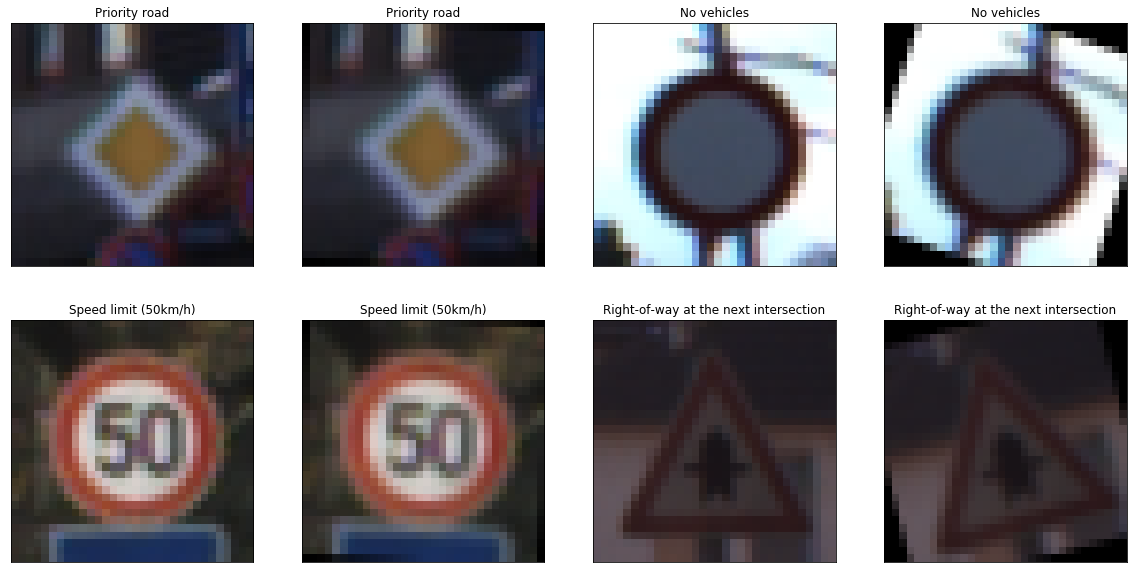

In [28]:
idx = np.random.randint(X_valid.shape[0], size=10)
plot_side_by_side(X_valid[idx,...], rotate(X_valid[idx,...]), y_valid[idx,...], sample=False)

### Resizing image to fit a pretrained model

In [29]:
def resize(X, width=48, height=48):
    X_new = np.zeros((X.shape[0], width, height, X.shape[-1]))
    for i in range(X.shape[0]):
        X_new[i,:,:,:] = cv2.resize(X[i,:,:,:],(width, height), interpolation = 3)
    return X_new

In [30]:
def apply_transform(X, transforms):
    if isinstance(X, dict):
        tmp = {}
        for k in X:
            tmp[k] = X[k]
            for t in transforms:
                tmp[k] = t(tmp[k])
        return tmp
    else:
        X_pre = X.copy()
        for t in transforms:
            X_pre = t(X_pre)
        return X_pre

In [31]:
X = {
        "train": X_train
        ,"test": X_test
        ,"valid": X_valid
    }

Y = {
        "train": y_train
        ,"test": y_test
        ,"valid": y_valid
    }

In [32]:
# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train, n_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, n_classes)
y_valid_one_hot = keras.utils.to_categorical(y_valid, n_classes)

Y_one_hot = {
        "train": y_train_one_hot
        ,"test": y_test_one_hot
        ,"valid": y_valid_one_hot
    }

### Fit Generator

In [33]:
from sklearn.utils import shuffle
import itertools

In [34]:
def fit_generator(X_train, y_train_one_hot, batch_size=256, preprocessors=[], data_agumentations=[]):
    n = X_train.shape[0]
    n_dg = len(data_agumentations)
    step_size = np.ceil(batch_size/(1+n_dg)).astype(int)
    
    X_train = apply_transform(X_train, preprocessors)    
    while 1:
        X, y = shuffle(X_train, y_train_one_hot)
        range_end = n-n%step_size
        if range_end<step_size:
            raise RuntimeError("input array is not of sufficient length")
        for i in range(0, range_end, step_size):
            X_b = X[i:i+step_size,...]
            X_batch = [X_b]
            y_batch = np.array(list(y[i:i+step_size,...])*(1+n_dg))
            for dg in data_agumentations:
                X_batch.append(dg(X_b))
            X_batch = np.concatenate(X_batch)
            if X_batch.shape[0]>batch_size:
                X_batch = X_batch[:batch_size]
                y_batch = y_batch[:batch_size]
            yield (X_batch, y_batch)

In [35]:
fg = fit_generator(X_valid, y_valid, data_agumentations=[add_noise, rotate], batch_size=8, preprocessors=[grayscale])

(8, 32, 32, 1) (8,)


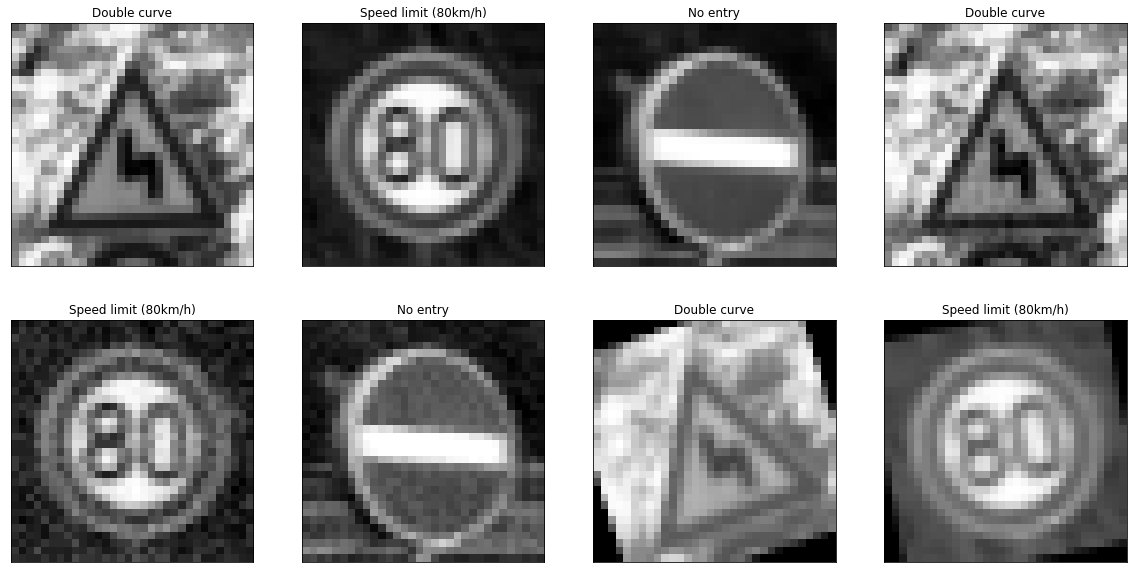

In [36]:
for x,y in fg:
    print(x.shape, y.shape)
    plot_samples(x,y,rows=2,sample=False)
    break

### Model Architecture

## Basic CNN model
Modeled after Keras example https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py <br>
I added few layers to the above model to get the accuracy from 93% to 97%.

In [37]:
def basic_cnn_model_v0(image_shape, n_classes, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=image_shape, name = "conv1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool1"))
    model.add(Dropout(0.25, name = "dropout1"))
    model.add(Flatten(name = "flatten1"))
    model.add(Dense(128, activation='relu', name = "dense1"))
    model.add(Dropout(0.5, name = "dropout2"))
    model.add(Dense(n_classes, activation='softmax', name = "softmax1"))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [38]:
bcnn = basic_cnn_model_v0(image_shape=image_shape, n_classes=n_classes)
bcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 14, 14, 64)        0         
_________________________________________________________________
flatten1 (Flatten)           (None, 12544)             0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1605760   
_________________________________________________________________
dropout2 (Dropout)           (None, 128)               0         
__________

In [39]:
def basic_cnn_model_v1(image_shape, n_classes, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=image_shape, name = "conv1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool1"))
    model.add(Dropout(0.25, name = "dropout1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv3"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool2"))
    model.add(Dropout(0.25, name = "dropout2"))
    model.add(Flatten(name = "flatten1"))
    model.add(Dense(128, activation='relu', name = "dense1"))
    model.add(Dropout(0.5, name = "dropout3"))
    model.add(Dense(128, activation='relu', name = "dense2"))
    model.add(Dropout(0.5, name = "dropout4"))
    model.add(Dense(n_classes, activation='softmax', name = "softmax1"))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [40]:
bcnn = basic_cnn_model_v1(image_shape=image_shape, n_classes=n_classes)
bcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 14, 14, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        36928     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 6, 6, 64)          0         
_________________________________________________________________
dropout2 (Dropout)           (None, 6, 6, 64)          0         
__________

In [41]:
def basic_cnn_model_v2(image_shape, n_classes, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=image_shape, name = "conv1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool1"))
    model.add(Dropout(0.5, name = "dropout1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv3"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool2"))
    model.add(Dropout(0.5, name = "dropout2"))
    model.add(Flatten(name = "flatten1"))
    model.add(Dense(128, activation='relu', name = "dense1"))
    model.add(Dropout(0.5, name = "dropout3"))
    model.add(Dense(128, activation='relu', name = "dense2"))
    model.add(Dropout(0.5, name = "dropout4"))
    model.add(Dense(n_classes, activation='softmax', name = "softmax1"))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [42]:
bcnn = basic_cnn_model_v2(image_shape=image_shape, n_classes=n_classes)
bcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 14, 14, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 12, 12, 64)        36928     
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 6, 6, 64)          0         
_________________________________________________________________
dropout2 (Dropout)           (None, 6, 6, 64)          0         
__________

In [43]:
def basic_cnn_model_v3(image_shape, n_classes, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=image_shape, name = "conv1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool1"))
    model.add(Dropout(0.7, name = "dropout1"))
    model.add(Conv2D(64, (3, 3), activation='relu', name = "conv3"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool2"))
    model.add(Dropout(0.7, name = "dropout2"))
    model.add(Conv2D(43, (3, 3), activation='relu', name = "conv4"))
    model.add(MaxPooling2D(pool_size=(2, 2), name = "maxpool3"))
    model.add(Dropout(0.7, name = "dropout3"))
    model.add(Flatten(name = "flatten1"))
    model.add(Dense(128, activation='relu', name = "dense1"))
    model.add(Dropout(0.7, name = "dropout4"))
    model.add(Dense(n_classes, activation='softmax', name = "softmax1"))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### Pretrained VGG16 model

In [44]:
def vgg16(image_shape, n_classes, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy']
          , freeze_all_layers = False, trainable_layers = []):
    
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet'
                                                , input_tensor=None, input_shape=image_shape)
    if freeze_all_layers:
        for layer in base_model.layers:
            layer.trainable = False

    for name in trainable_layers:
        base_model.get_layer(name).trainable = True

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(n_classes, activation='softmax')(x)

    vgg = Model(input=base_model.input, output=predictions)
    vgg.compile(loss=keras.losses.categorical_crossentropy,optimizer=optimizer, metrics=metrics)
    
    return vgg

In [45]:
vgg16(image_shape=(48,48,3), n_classes=n_classes).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


### Model Training

In [46]:
#http://stackoverflow.com/questions/26646362/numpy-array-is-not-json-serializable
def jsonify(data):
    json_data = dict()
    for key, value in data.items():
        if isinstance(value, list): # for lists
            value = [ jsonify(item) if isinstance(item, dict) else item for item in value ]
        if isinstance(value, dict): # for nested lists
            value = jsonify(value)
        if isinstance(key, int): # if key is integer: > to string
            key = str(key)
        if type(value).__module__=='numpy': # if value is numpy.*: > to python list
            value = value.tolist()
        json_data[key] = value
    return json_data

In [47]:
def train_model(X, Y, model_fn=None, model=None, data_agumentations=[add_noise, rotate, blur, shift]
                ,epochs=1,batch_size=256, save_model=True, preprocessors=[]):
    
    #generating fit generator instance
    fg = fit_generator(X['train'], Y['train'], data_agumentations=data_agumentations
                       , batch_size=batch_size, preprocessors = preprocessors)

    #finding image shape and #classes by running fit generator
    for x,y in fg:
        image_shape,n_classes = (x.shape[1:], y.shape[1])
        break

    #generating model instance 
    if model_fn:
        model = model_fn(image_shape=image_shape, n_classes=n_classes)
    
    #train the model
    history = model.fit_generator(fg
                        ,steps_per_epoch = np.ceil(X['train'].shape[0]*(1+len(data_agumentations))/batch_size).astype(int)
                        ,epochs=epochs
                        ,validation_data=(apply_transform(X['valid'], preprocessors), Y['valid']))
    
    if save_model:
        #save the trained model and info associated with it
        if model_fn:
            model_name = model_fn.__name__
        else:
            model_name = "unknown"
        model_info = {
            "model_name": model_name
            ,"data_agumentations": [x.__name__ for x in data_agumentations]
            ,"preprocessors": [x.__name__ for x in preprocessors]
            ,"ts_complete": datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
            ,"epochs": epochs
            ,"batch_size": batch_size
            ,"params": history.params
            ,"history": history.history
        }
        file_name = "models/" + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        with open(file_name+".json", 'w') as f:
            f.write(json.dumps(jsonify(model_info)))
        model.save(file_name +".h5")
    
    return history

In [ ]:
train_model(X,Y_one_hot,basic_cnn_model,epochs=10,batch_size=2048, preprocessors=[grayscale])

### Loading and evaluating saved models

In [49]:
def evaluate_model(X, Y, model):
    accuracy = []
    loss = []
    dataset = []
    for k in X:
        score = model.evaluate(X[k], Y[k], verbose=0)
        loss.append(score[0])
        accuracy.append(score[1])
        dataset.append(k)
    df = pd.DataFrame({
        "dataset": dataset
        ,'accuracy': accuracy
        ,"loss": loss
    }).set_index("dataset")
    return df

In [50]:
!ls -ltrh models/*.json

-rw-r--r--@ 1 karthik  admin   133B Apr 15 02:24 models/2017_04_14_23_36_26.json
-rw-r--r--@ 1 karthik  admin   133B Apr 15 02:24 models/2017_04_14_20_57_31.json
-rw-r--r--@ 1 karthik  admin   171B Apr 15 02:24 models/2017_04_14_18_55_20.json
-rw-r--r--@ 1 karthik  admin   1.2K Apr 15 05:08 models/2017_04_15_12_08_13.json
-rw-r--r--@ 1 karthik  admin   1.0K Apr 15 11:06 models/2017_04_15_18_06_34.json
-rw-r--r--@ 1 karthik  admin    16K Apr 16 14:04 models/2017_04_16_21_04_47.json


In [60]:
models_info = []
for file in glob.glob("models/*.json"):
    json_str = open(file, 'r').read()
    try:
        model_info = json.loads(json_str)
        models_info.append(model_info)
    except:
        print("Error reading {}".format(file))
        continue

In [61]:
df_models = pd.DataFrame(models_info).set_index("ts_complete")

In [62]:
df_models

,batch_size,data_agumentations,epochs,history,model_name,params,preprocessors
ts_complete,,,,,,,
2017_04_14_18_55_20,2048,"[add_noise, rotate, blur, shift]",1000,NaN,basic_cnn_model,NaN,NaN
2017_04_14_20_57_31,2048,[],1000,NaN,basic_cnn_model,NaN,NaN
2017_04_14_23_36_26,4096,[],1000,NaN,basic_cnn_model,NaN,NaN
2017_04_15_12_08_13,512,"[add_noise, rotate, blur, shift]",10,"{'val_acc': [0.6299287401015855, 0.95067300138...",vgg16,"{'metrics': ['loss', 'acc', 'val_loss', 'val_a...",[resize]
2017_04_15_18_06_34,512,"[add_noise, rotate, blur, shift]",8,"{'val_acc': [0.6256532065658841, 0.88091844770...",vgg16,"{'metrics': ['loss', 'acc', 'val_loss', 'val_a...",[resize]
2017_04_16_21_04_47,2048,"[add_noise, rotate, blur, shift]",200,"{'val_loss': [3.153572217038201, 2.28714549660...",basic_cnn_model_v1,"{'epochs': 200, 'steps': 85, 'do_validation': ...",[]


In [54]:
def load_eval_models(X, Y, df):
    df = df.copy().reset_index(drop=True)
    preprocessors_map = {
        "grayscale": grayscale
        ,"resize": resize
        ,"<lambda>": lambda x : resize(x, width=112, height=112)
    }
    df.loc[:, "test_loss"] = None
    df.loc[:, "test_acc"] = None
    
    for i in range(len(df)):
        model_info = df.loc[i]
        print("Evaluating " + model_info.model_name)
        file = "/Volumes/hd2/workspace/temp/models_traffic/{}.h5".format(model_info.ts_complete)
        if not model_info[["preprocessors"]].isnull()[0]:
            preprocessor = [preprocessors_map[x] for x in model_info.preprocessors]
        else:
            preprocessor = []
        model = load_model(file)
        X_pre = apply_transform(X, preprocessor)
        loss, accuracy = model.evaluate(X_pre['test'], Y['test'], verbose=0)
        df.loc[i, "test_loss"] = loss
        df.loc[i, "test_acc"] = accuracy        
        print("{} has test accuracy of {} ".format(model_info.model_name, accuracy))
    return df

In [55]:
### models are evaluated on cloud instance and got following results
from io import StringIO
stats = StringIO("""ts_complete	test_acc
2017_04_16_21_04_47	0.980048
2017_04_14_23_36_26	0.986382
2017_04_14_20_57_31	0.983848
2017_04_14_18_55_20	0.983848
2017_04_15_18_06_34	0.98171
2017_04_15_12_08_13	0.967933""")
df_model_acc = pd.read_csv(stats, sep='\t').set_index("ts_complete")
df_model_acc

,test_acc
ts_complete,
2017_04_16_21_04_47,0.980048
2017_04_14_23_36_26,0.986382
2017_04_14_20_57_31,0.983848
2017_04_14_18_55_20,0.983848
2017_04_15_18_06_34,0.981710
2017_04_15_12_08_13,0.967933


In [63]:
df_models_stats = df_models.join(df_model_acc)
df_models_stats

,batch_size,data_agumentations,epochs,history,model_name,params,preprocessors,test_acc
ts_complete,,,,,,,,
2017_04_14_18_55_20,2048,"[add_noise, rotate, blur, shift]",1000,NaN,basic_cnn_model,NaN,NaN,0.983848
2017_04_14_20_57_31,2048,[],1000,NaN,basic_cnn_model,NaN,NaN,0.983848
2017_04_14_23_36_26,4096,[],1000,NaN,basic_cnn_model,NaN,NaN,0.986382
2017_04_15_12_08_13,512,"[add_noise, rotate, blur, shift]",10,"{'val_acc': [0.6299287401015855, 0.95067300138...",vgg16,"{'metrics': ['loss', 'acc', 'val_loss', 'val_a...",[resize],0.967933
2017_04_15_18_06_34,512,"[add_noise, rotate, blur, shift]",8,"{'val_acc': [0.6256532065658841, 0.88091844770...",vgg16,"{'metrics': ['loss', 'acc', 'val_loss', 'val_a...",[resize],0.981710
2017_04_16_21_04_47,2048,"[add_noise, rotate, blur, shift]",200,"{'val_loss': [3.153572217038201, 2.28714549660...",basic_cnn_model_v1,"{'epochs': 200, 'steps': 85, 'do_validation': ...",[],0.980048


In [92]:
df_model_final_stats = df_models_stats.copy()
df_model_final_stats.loc[:, "model_name"] = df_models_stats.model_name.apply(
    lambda x: "v1" if "basic_cnn_model" in x else x)
df_model_final_stats = df_model_final_stats[["model_name", "batch_size", "epochs","data_agumentations", "test_acc"]]
df_model_final_stats.columns = ["Model Name", "Batch Size", "#Epochs", "Data Augmentation", "Test Accuracy"]
df_model_final_stats.sort_values(["Test Accuracy"], ascending=False).reset_index(drop=True)

,Model Name,Batch Size,#Epochs,Data Augmentation,Test Accuracy
0,v1,4096,1000,[],0.986382
1,v1,2048,1000,"[add_noise, rotate, blur, shift]",0.983848
2,v1,2048,1000,[],0.983848
3,vgg16,512,8,"[add_noise, rotate, blur, shift]",0.981710
4,v1,2048,200,"[add_noise, rotate, blur, shift]",0.980048
5,vgg16,512,10,"[add_noise, rotate, blur, shift]",0.967933


### Confusion Matrix

In [128]:
from sklearn.metrics import confusion_matrix
pd.set_option('max_columns', 100)

In [129]:
def get_cm(y, y_pred):
    cm = pd.DataFrame(confusion_matrix(y, y_pred))
    cm.index = signnames
    cm.index.name = "Real Label"
    cm.columns = signnames

In [87]:
get_cm(y, y_pred)

SignName,Speed limit (20km/h),Speed limit (30km/h),Speed limit (50km/h),Speed limit (60km/h),Speed limit (70km/h),Speed limit (80km/h),End of speed limit (80km/h),Speed limit (100km/h),Speed limit (120km/h),No passing,No passing for vehicles over 3.5 metric tons,Right-of-way at the next intersection,Priority road,Yield,Stop,No vehicles,Vehicles over 3.5 metric tons prohibited,No entry,General caution,Dangerous curve to the left,Dangerous curve to the right,Double curve,Bumpy road,Slippery road,Road narrows on the right,Road work,Traffic signals,Pedestrians,Children crossing,Bicycles crossing,Beware of ice/snow,Wild animals crossing,End of all speed and passing limits,Turn right ahead,Turn left ahead,Ahead only,Go straight or right,Go straight or left,Keep right,Keep left,Roundabout mandatory,End of no passing,End of no passing by vehicles over 3.5 metric tons
Predicted Label,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Speed limit (20km/h),30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (30km/h),0,235,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0
Speed limit (50km/h),0,2,239,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (60km/h),0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (70km/h),0,3,0,0,210,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (80km/h),0,0,0,0,0,209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
End of speed limit (80km/h),0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (100km/h),0,0,0,0,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Speed limit (120km/h),0,0,0,0,0,0,0,0,148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


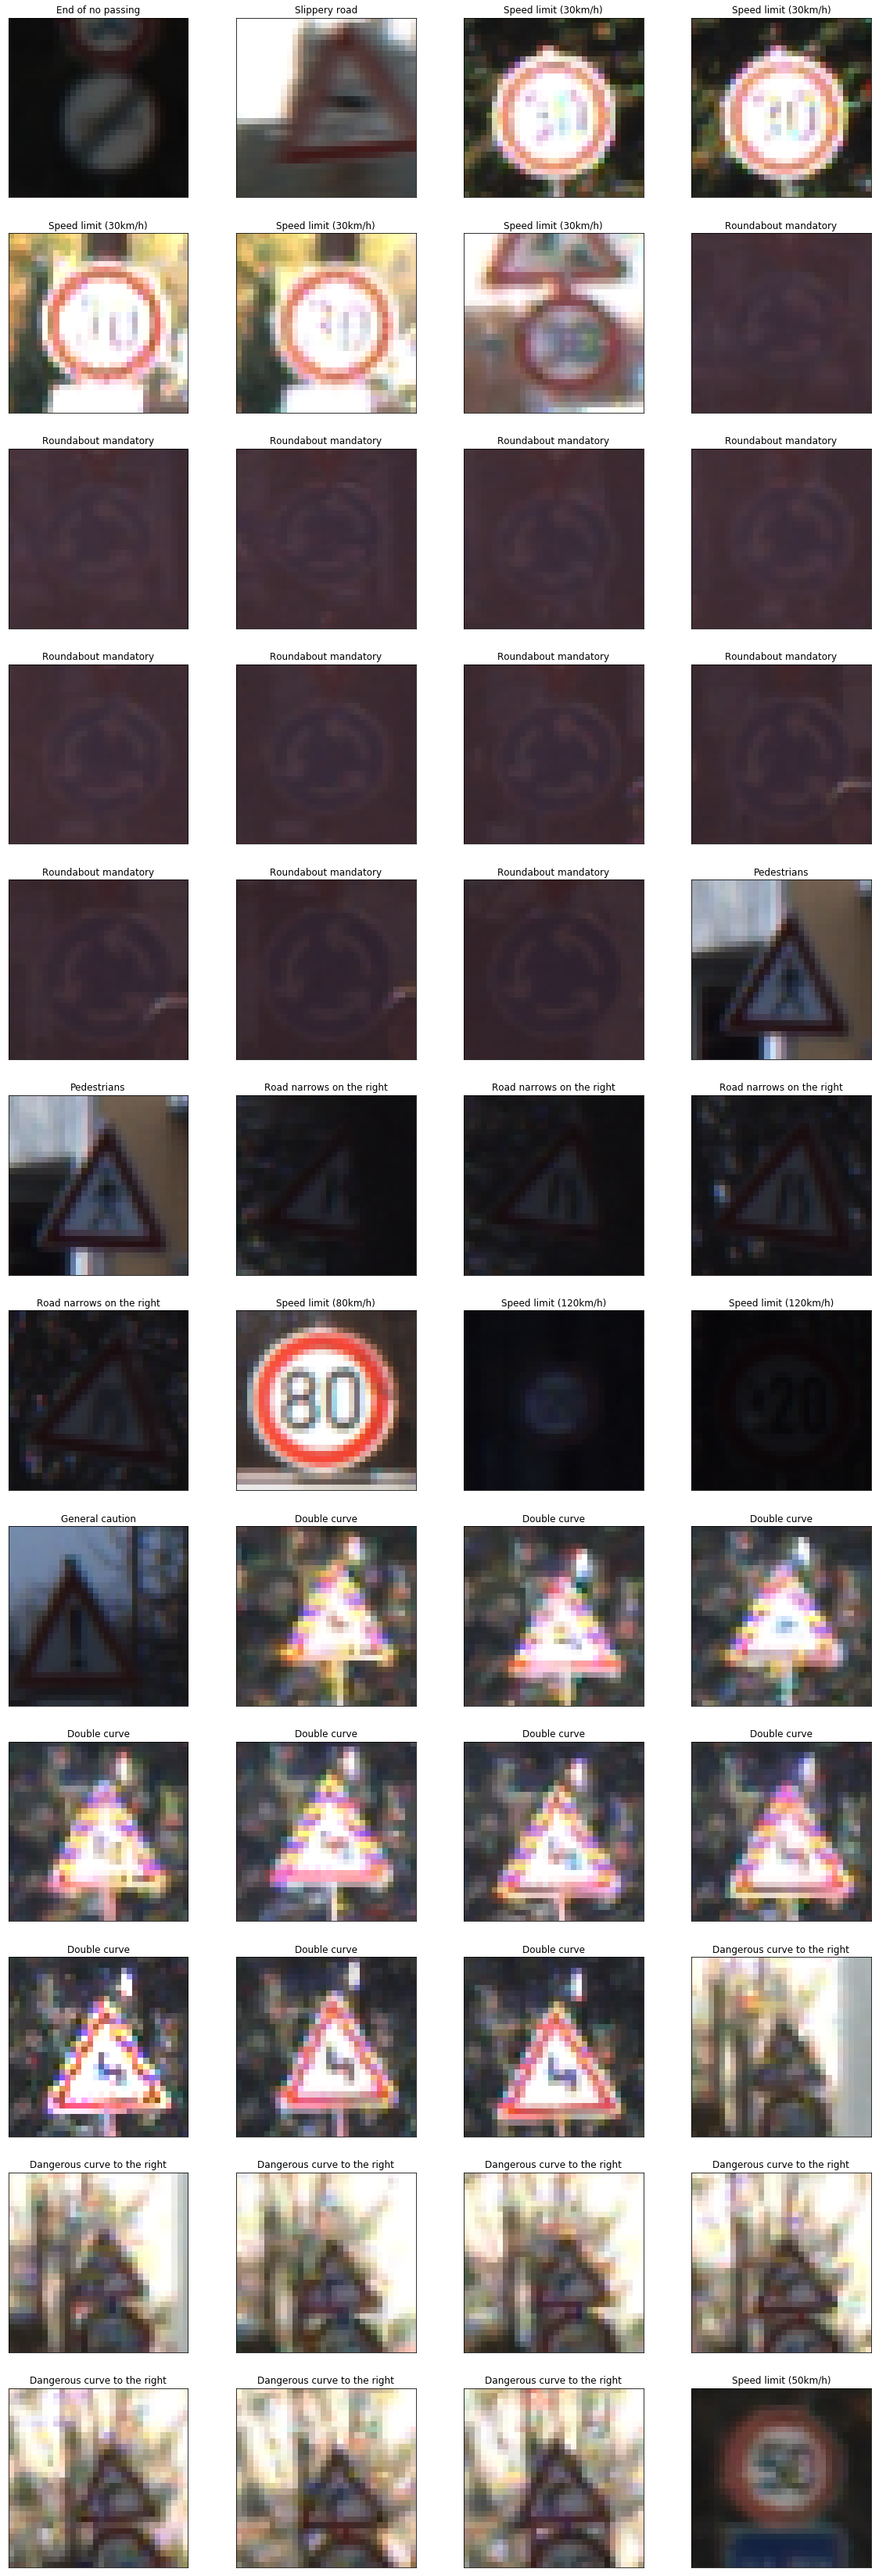

In [102]:
plot_samples(X_valid[y_valid!=a,:,:,:],y_valid[y_valid!=y_pred],rows=4, cols=7, sample=True)

In [91]:
for c in cm:
    ts = cm[c].sort_values(ascending=False)
    if ts[1] >0:
        print(c)
        print(ts.head(4)[1:])
        print()

Speed limit (30km/h)
Predicted Label
Speed limit (70km/h)                                  3
Speed limit (50km/h)                                  2
End of no passing by vehicles over 3.5 metric tons    0
Name: Speed limit (30km/h), dtype: int64

Speed limit (50km/h)
Predicted Label
Speed limit (30km/h)                                  1
End of no passing by vehicles over 3.5 metric tons    0
Right-of-way at the next intersection                 0
Name: Speed limit (50km/h), dtype: int64

Speed limit (80km/h)
Predicted Label
Speed limit (30km/h)                                  1
End of no passing by vehicles over 3.5 metric tons    0
Right-of-way at the next intersection                 0
Name: Speed limit (80km/h), dtype: int64

Speed limit (120km/h)
Predicted Label
Speed limit (50km/h)                                  1
Speed limit (70km/h)                                  1
End of no passing by vehicles over 3.5 metric tons    0
Name: Speed limit (120km/h), dtype: int64

General ca

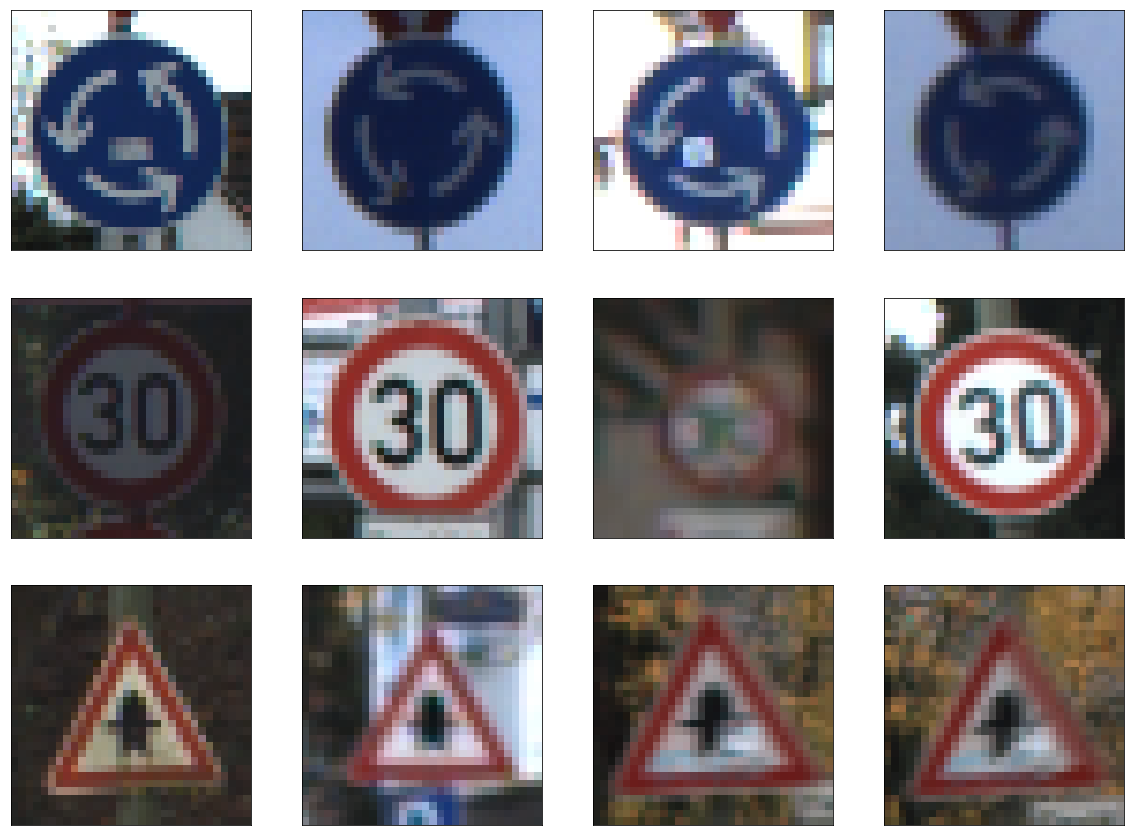

In [100]:
labels_tmp = signnames_rev.loc[['Roundabout mandatory', "Speed limit (30km/h)", "Right-of-way at the next intersection"]].values 
buf = get_images_by_label(X_test, y_test, labels_tmp)
plot_samples(buf,None,rows=len(labels_tmp), cols=4, sample=False)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [74]:
urls =[
    'http://a.rgbimg.com/cache1nHmS6/users/s/su/sundstrom/300/mifuUb0.jpg'
    #,'https://www.gumiabroncsakciok.hu/uploaded_images/t%C3%A9ligumi%20165_70r142.jpg'
    ,'http://signx.info/neon-signs/traffic-signs-german.jpg'
    ,'http://bicyclegermany.com/Images/Laws/100_1607.jpg'
    ,'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-German-traffic-sign-No-205-give-way-Stock-Photo.jpg'
    ,'http://www.expressway.online/oldsite/photogallery/signs/general/regulatory/images/giveway.jpg'
    ,'http://exviking.net/road/extra/elk.jpg'
    ,'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381075'
    ,'http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381295'
]

In [76]:
for i, url in enumerate(urls):
    print(url)
    urllib.request.urlretrieve(url, "images/{}.jpg".format(i))

http://a.rgbimg.com/cache1nHmS6/users/s/su/sundstrom/300/mifuUb0.jpg
http://signx.info/neon-signs/traffic-signs-german.jpg
http://bicyclegermany.com/Images/Laws/100_1607.jpg
https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-German-traffic-sign-No-205-give-way-Stock-Photo.jpg
http://www.expressway.online/oldsite/photogallery/signs/general/regulatory/images/giveway.jpg
http://exviking.net/road/extra/elk.jpg
http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381075
http://media.gettyimages.com/photos/german-traffic-signs-picture-id459381295


### Load and Output the Images

In [82]:
labels_internet = ["Road work"
                   ,"Right-of-way at the next intersection"
                  ,"Yield"
                   ,"Yield"
                   ,"Wild animals crossing"
                  ,"Pedestrians"
                  ,"Children crossing"]
y_labels_internet = np.array([signnames_rev.loc[x].ClassId for x in labels_internet])

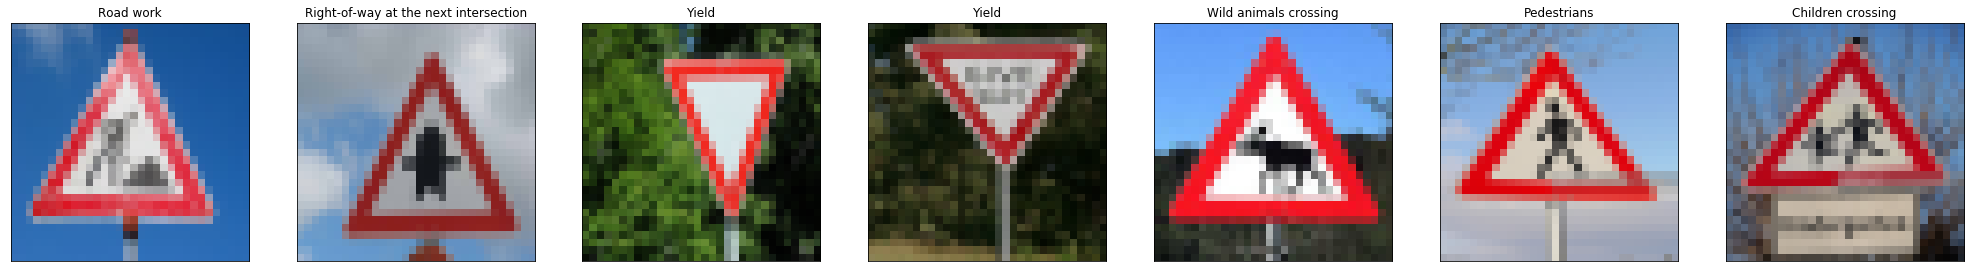

In [83]:
buf = []
files = np.sort(glob.glob("images/from_internet/[0,2,3,4,5,6,7].jpg"))
for file in files:
    img = cv2.resize(mpimg.imread(file),(image_shape[0], image_shape[1])
                     , interpolation = 3)
    buf.append(img)
test_images = np.array(buf)
test_images = normalize_0to1(test_images)
plot_samples(test_images,rows=1, cols=len(test_images), y=y_labels_internet,sample=False)

### Predict the Sign Type for Each Image

In [98]:
def load_eval_models_internet(X, Y, df):
    df = df.copy().reset_index(drop=True)
    preprocessors_map = {
        "grayscale": grayscale
        ,"resize": resize
        ,"<lambda>": lambda x : resize(x, width=112, height=112)
    }
    df.loc[:, "Test Accuracy (Internet Images)"] = None
    df.loc[:, "predictions"] = None
    
    for i in range(len(df)):
        model_info = df.loc[i]
        file = "models/{}.h5".format(model_info.ts_complete)
        if not model_info[["preprocessors"]].isnull()[0]:
            preprocessor = [preprocessors_map[x] for x in model_info.preprocessors]
        else:
            preprocessor = []
        model = load_model(file)
        X_pre = apply_transform(X, preprocessor)
        predictions = np.argmax(model.predict(X_pre['test']), axis=1) #model.predict_classes(X['test'])
        accuracy = (predictions==Y).sum()
        n = len(X['test'])
        print("Accuracy: {}/{} ".format(accuracy, n))
        df.loc[i, "Test Accuracy (Internet Images)"] = accuracy/n        
        df.loc[i, "predictions"] = ",".join(predictions.astype(str))
        #print("{} has test accuracy of {} ".format(model_info.model_name, accuracy))
    return df

In [100]:
df_internet = load_eval_models_internet({"test": test_images}, y_labels_internet, df_models_stats.reset_index())

Accuracy: 6/7 
Accuracy: 4/7 
Accuracy: 3/7 
Accuracy: 5/7 
Accuracy: 5/7 
Accuracy: 5/7 


In [105]:
a = df_internet[["ts_complete", "Test Accuracy (Internet Images)"]].set_index("ts_complete")
a = df_model_final_stats.join(a)
a.sort_values(["Test Accuracy (Internet Images)"], ascending=False)

,Model Name,Batch Size,#Epochs,Data Augmentation,Test Accuracy,Test Accuracy (Internet Images)
ts_complete,,,,,,
2017_04_14_18_55_20,v1,2048,1000,"[add_noise, rotate, blur, shift]",0.983848,0.857143
2017_04_15_12_08_13,vgg16,512,10,"[add_noise, rotate, blur, shift]",0.967933,0.714286
2017_04_15_18_06_34,vgg16,512,8,"[add_noise, rotate, blur, shift]",0.981710,0.714286
2017_04_16_21_04_47,v1,2048,200,"[add_noise, rotate, blur, shift]",0.980048,0.714286
2017_04_14_20_57_31,v1,2048,1000,[],0.983848,0.571429
2017_04_14_23_36_26,v1,4096,1000,[],0.986382,0.428571


In [112]:
buf = []
for i, p in enumerate(predictions):
    idxs_all = np.argwhere(y_valid==p).ravel()
    idxs = idxs_all[np.random.randint(idxs_all.shape[0], size=(6,))]
    buf.append(test_images[i,:,:,:])
    for idx in idxs:
        buf.append(X_valid[idx,:,:,:])
buf = np.array(buf)

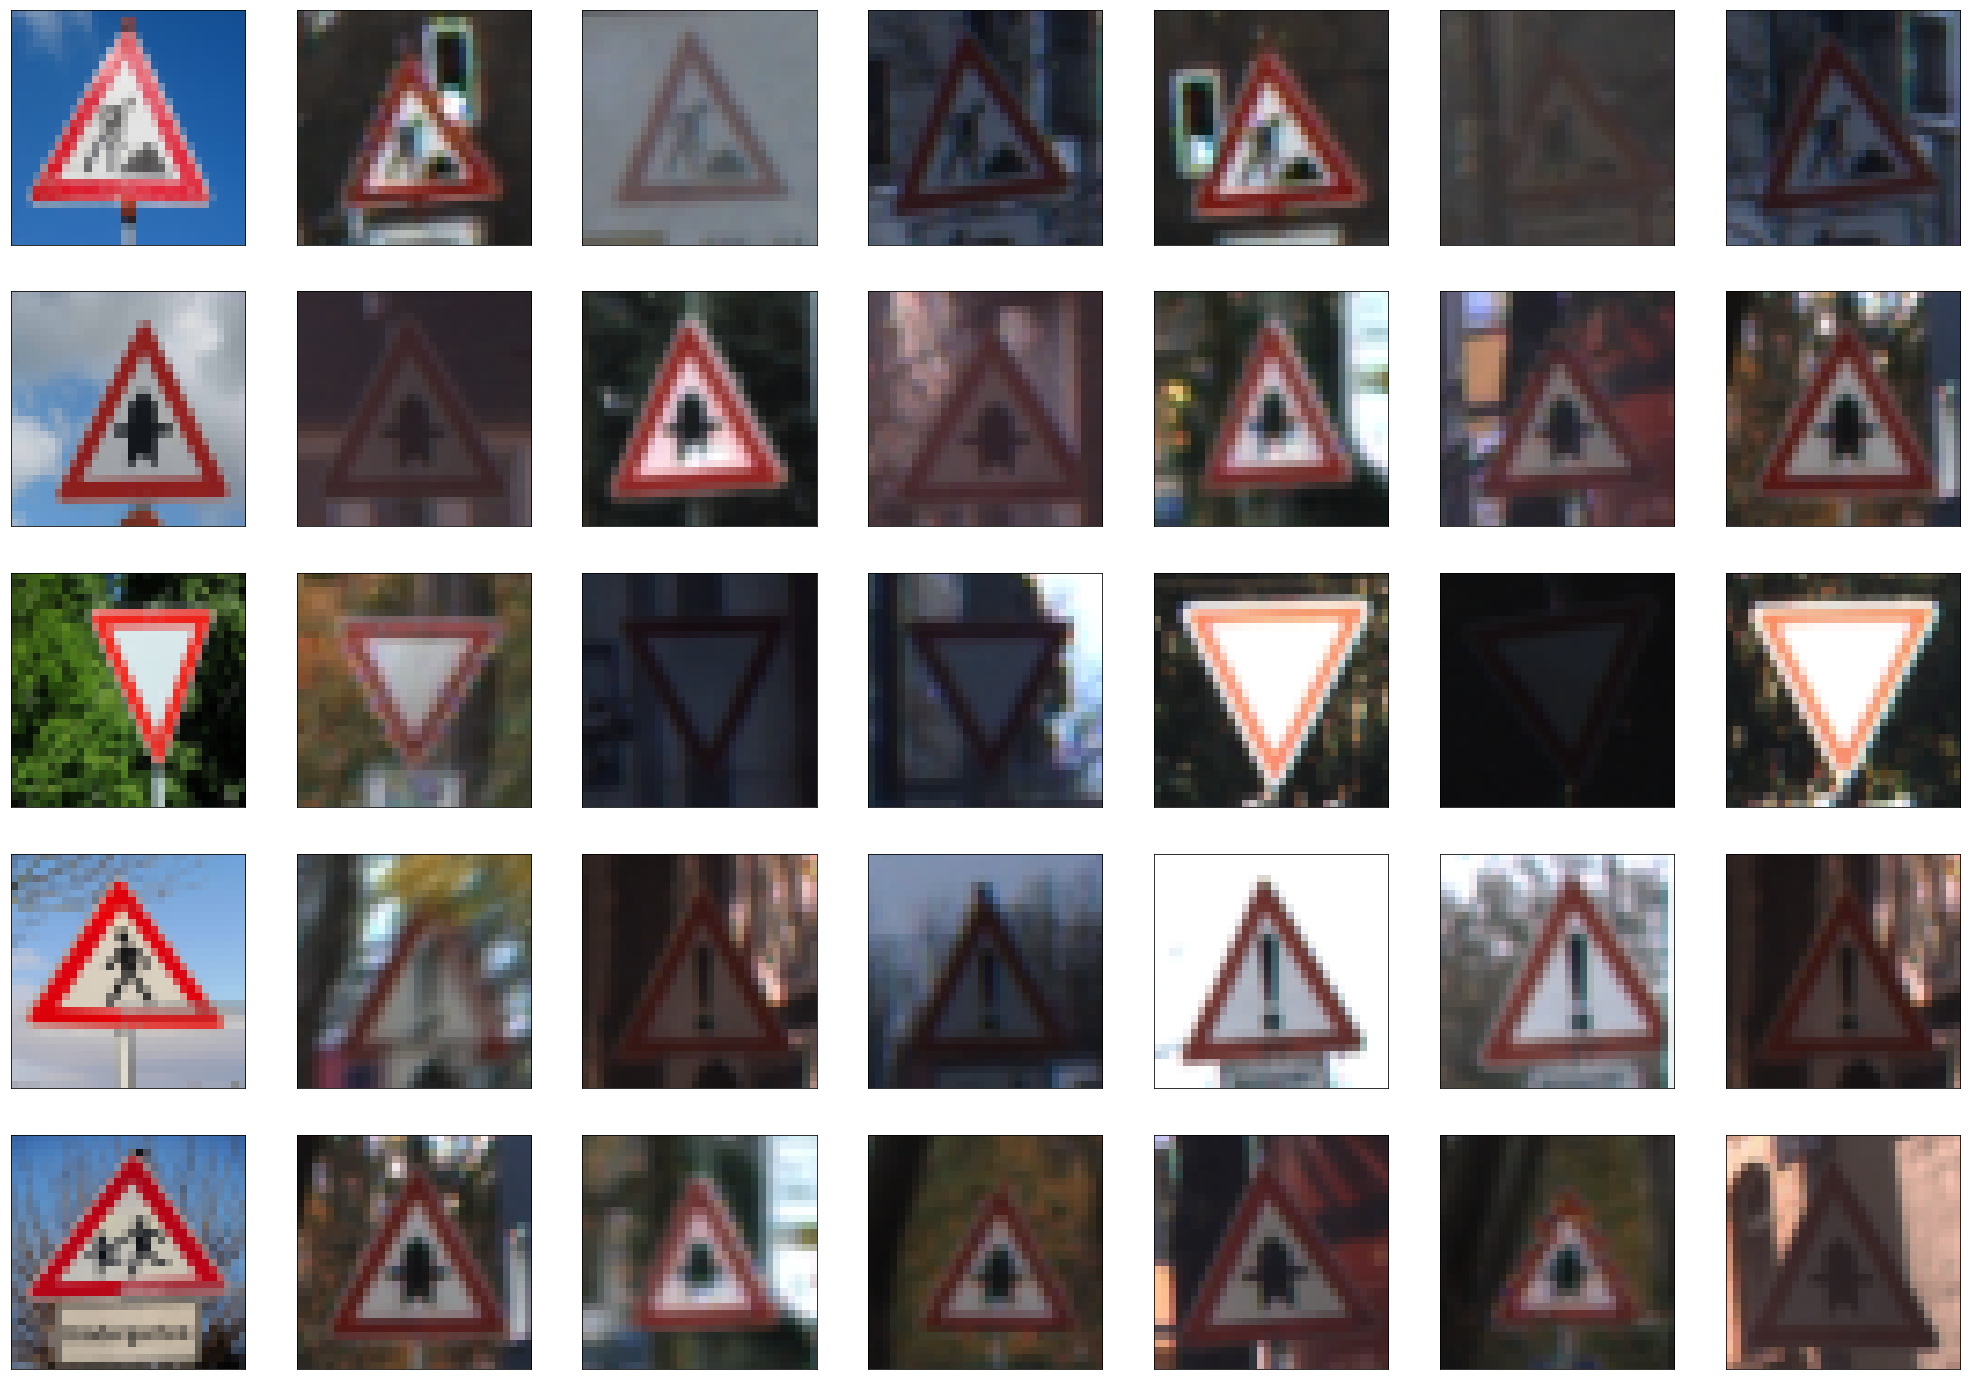

In [113]:
plot_samples(buf,y=None,rows=len(predictions), cols=7, sample=False)

In [290]:
buf = []
for i, p in enumerate(y_labels_internet):
    idxs_all = np.argwhere(y_valid==p).ravel()
    idxs = idxs_all[np.random.randint(idxs_all.shape[0], size=(6,))]
    buf.append(test_images[i,:,:,:])
    for idx in idxs:
        buf.append(X_valid[idx,:,:,:])
buf = np.array(buf)

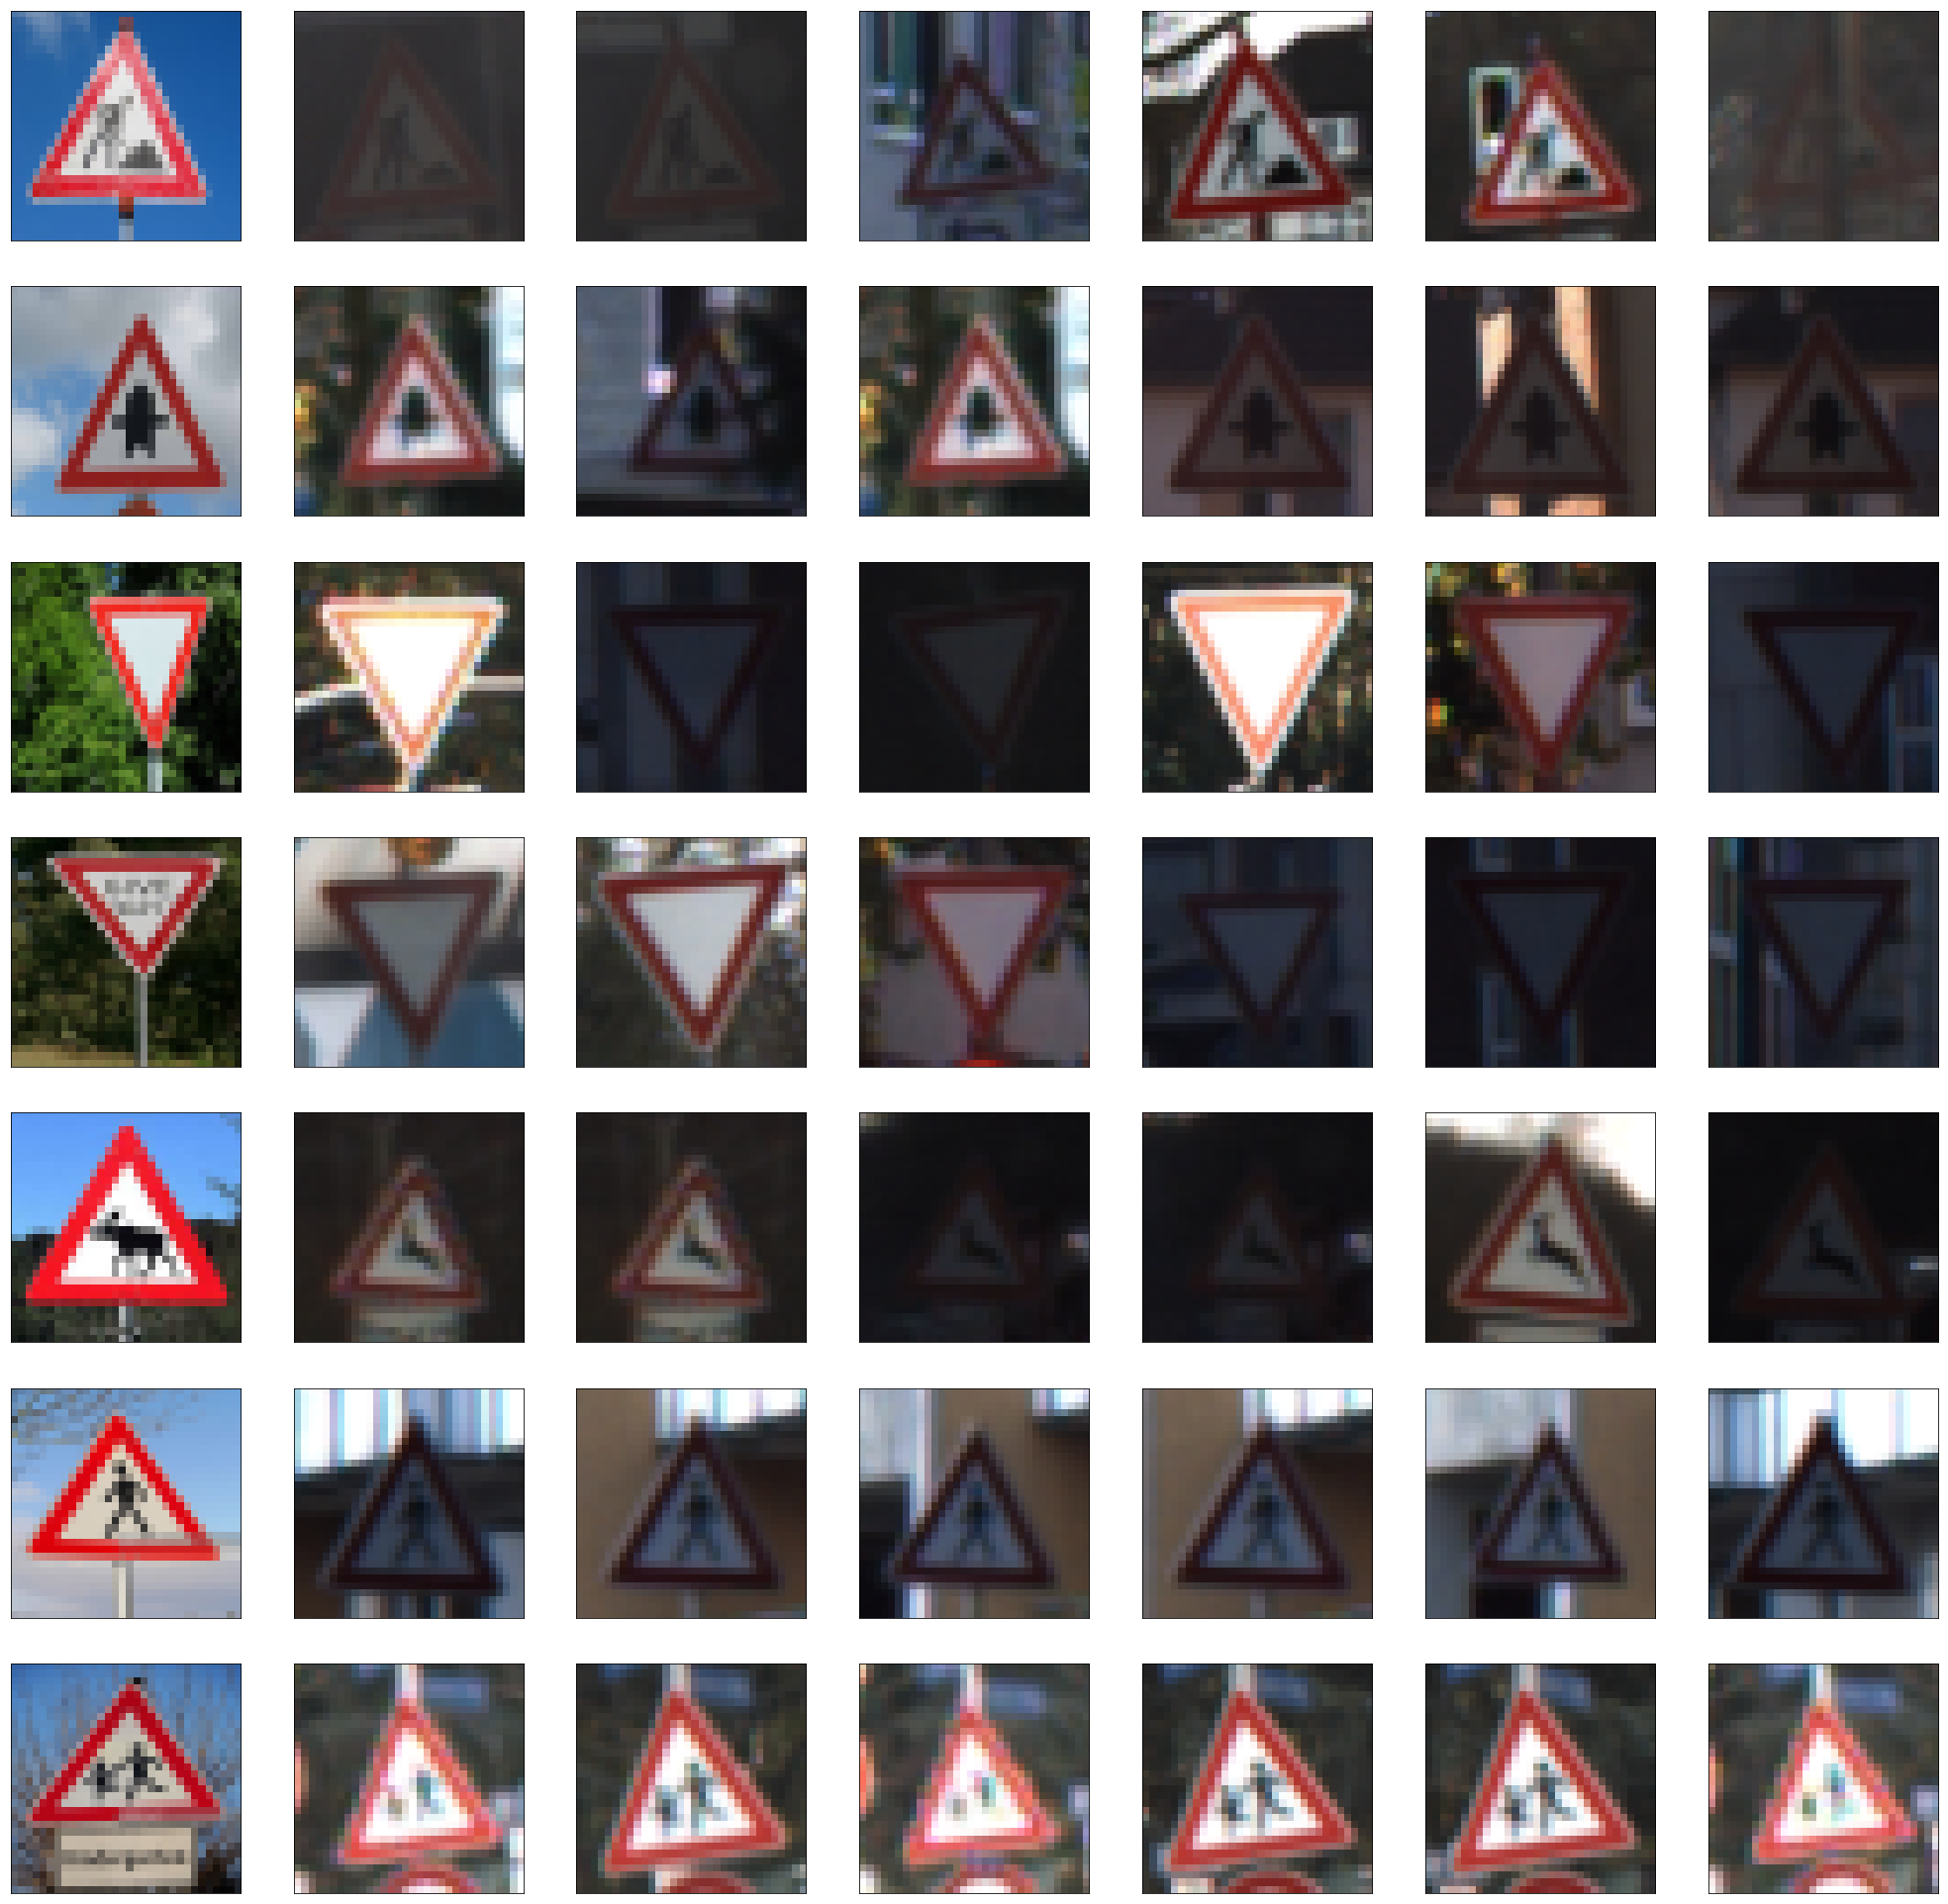

In [291]:
plot_samples(buf,y=None,rows=len(y_labels_internet), cols=7, sample=False)

In [117]:
def get_images_by_label(X, y, labels, size=4):
    buf = []
    for i, p in enumerate(labels):
        idxs_all = np.argwhere(y==p).ravel()
        idxs = idxs_all[np.random.randint(idxs_all.shape[0], size=(size,))]
        for idx in idxs:
            buf.append(X[idx,:,:,:])
    buf = np.array(buf)
    return buf

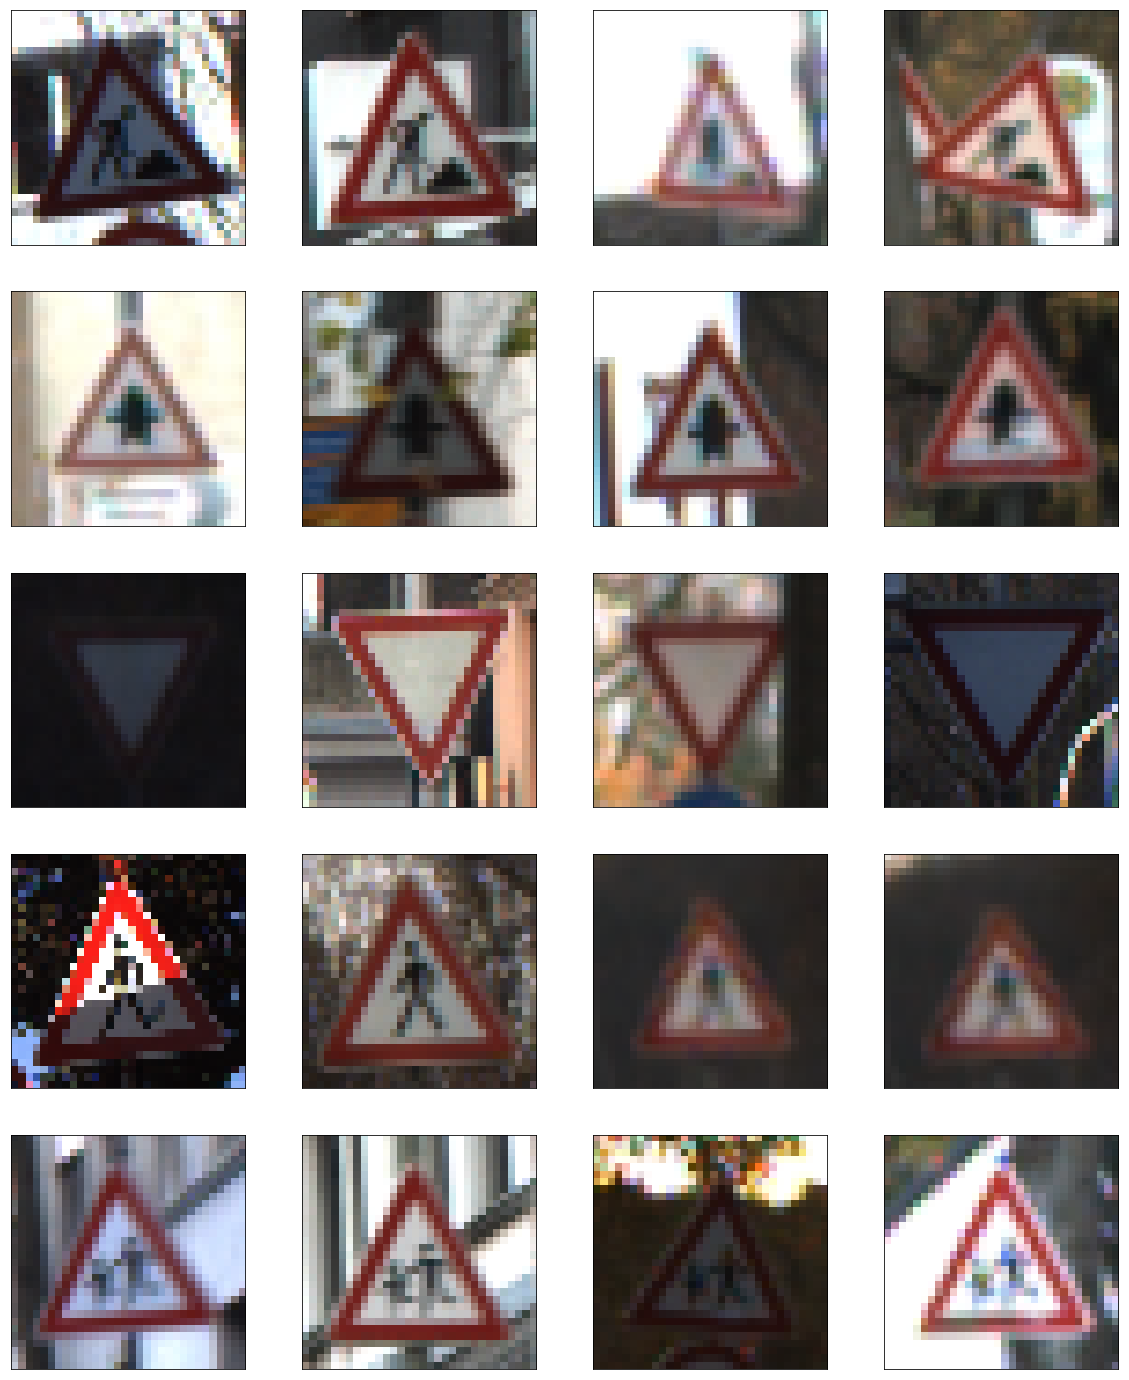

In [118]:
buf = get_images_by_label(X_test, y_test, y_labels_internet)
plot_samples(buf,None,rows=len(y_labels_internet), cols=4, sample=False)

### Analyze Performance

Out of 8 images that I found on the internet, following are the results: <br>
1. The 2nd image doesn't seem to belong a traffic sign in our dataset, so ignoring it. <br>
2. Out of 7 predictions, 4 were right. Therefore the accuracy is around 57% with big error bars as the sample size is very small. <br>

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [106]:
model = load_model("models/2017_04_14_18_55_20.h5")
predictions_prob = model.predict_proba(test_images)

7/7 [==============================] - 0s


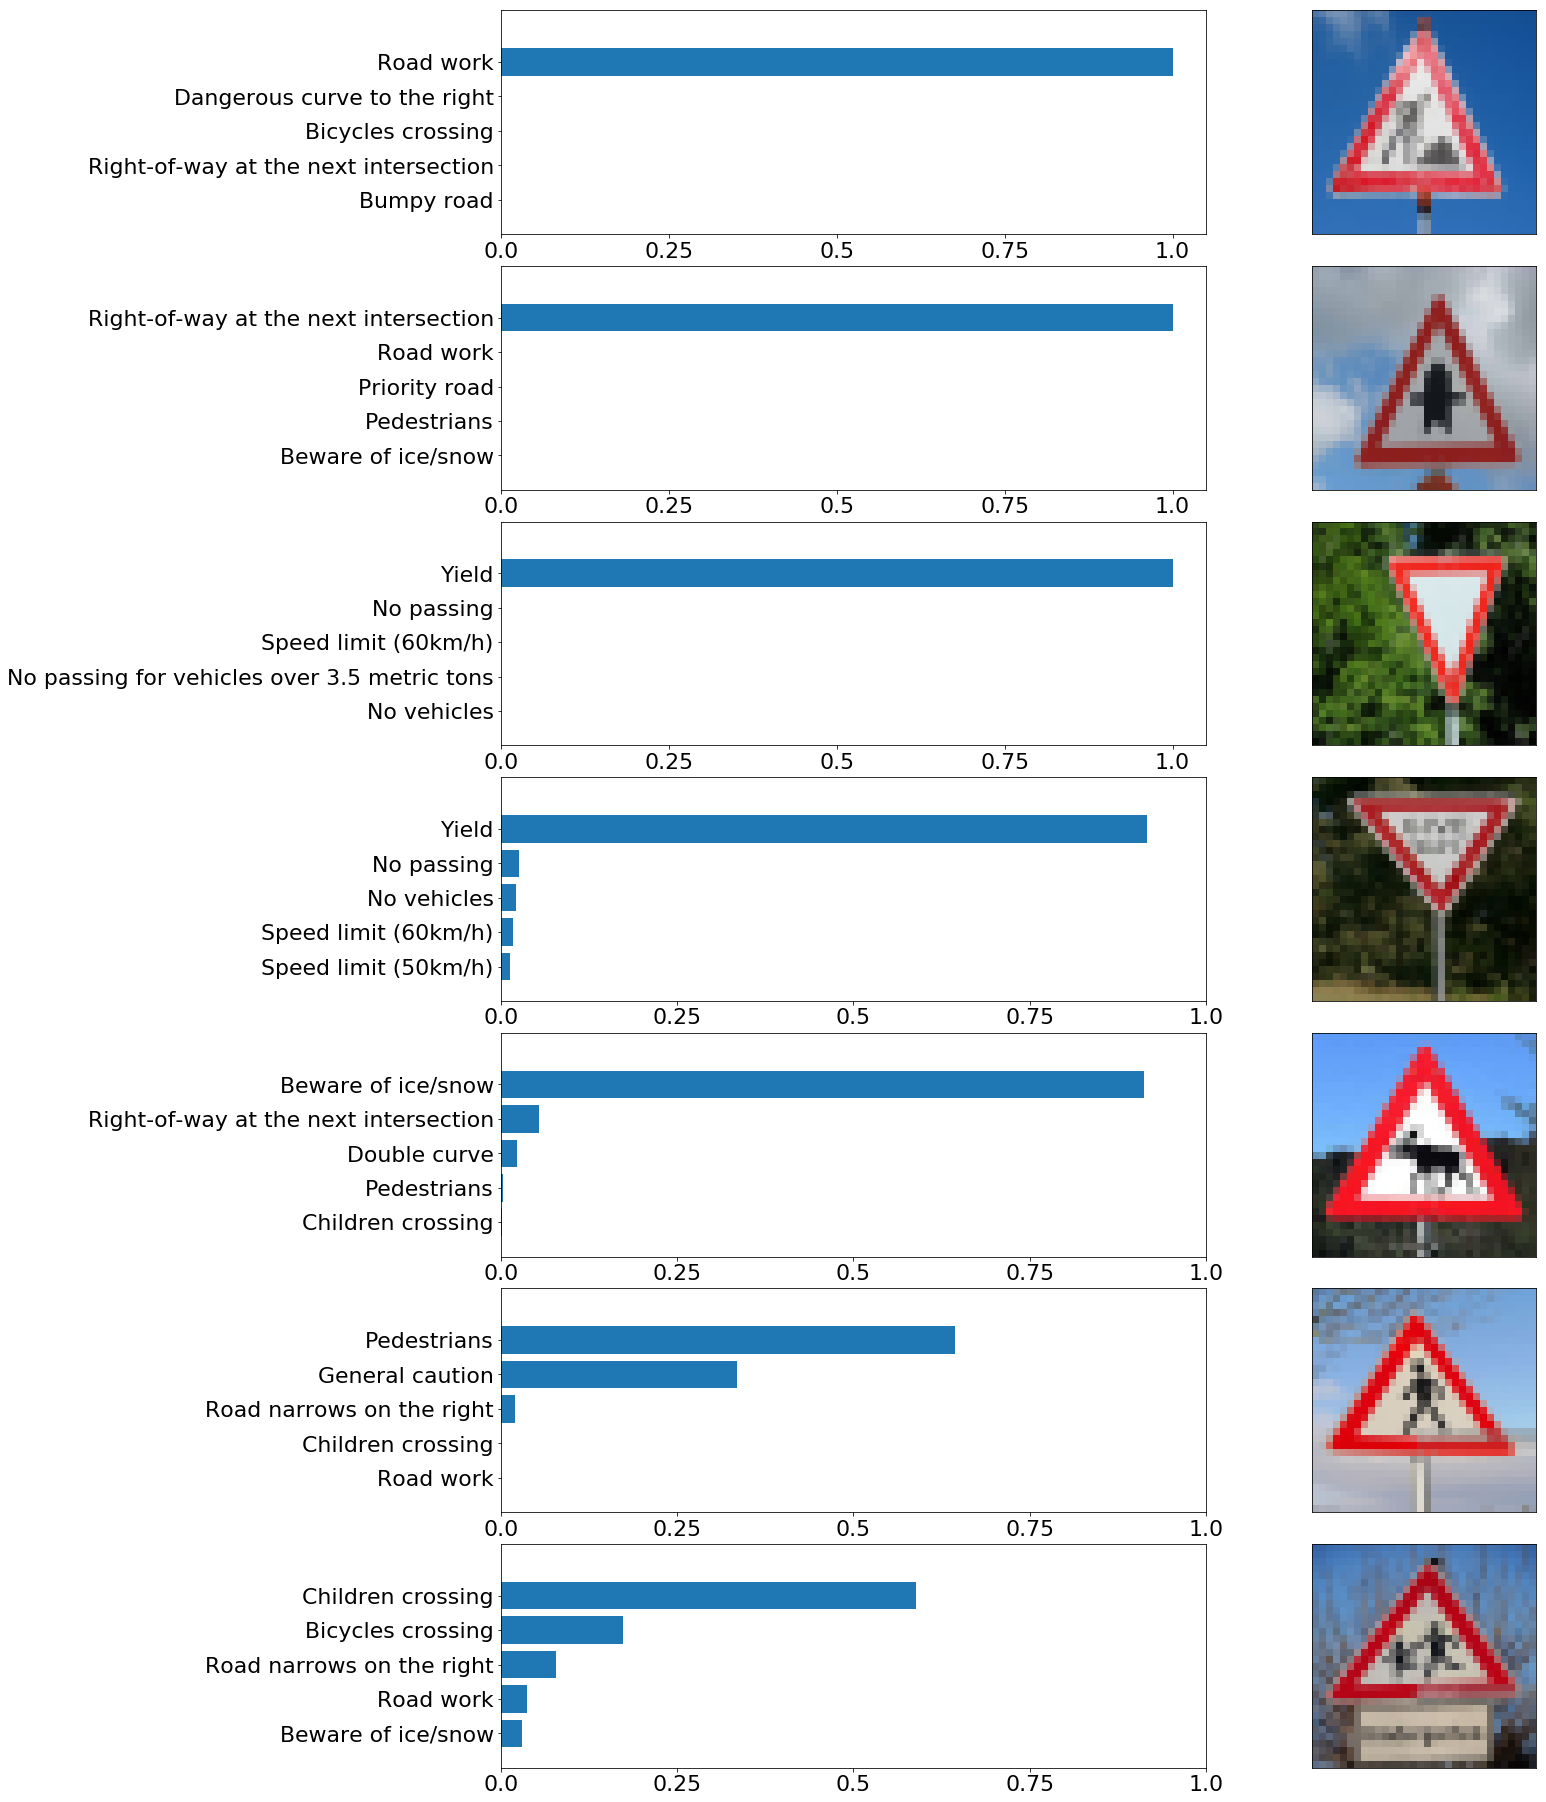

In [193]:
df = pd.DataFrame(predictions_prob.T).join(signnames).set_index("SignName")
f,ax = plt.subplots(len(test_images), 2,figsize=(16,25), gridspec_kw = {'width_ratios':[2, 1]})
plt.tight_layout()
for c, img,axi in zip(df.columns, test_images, ax):        
    stats = df[[c]].sort_values([c],ascending=False).head(5).round(4)
    stats = stats[stats.columns[0]]
    stats = stats.sort_values(ascending=False)
    pos = np.arange(len(stats)-1,-1,-1)+0.5
    axi[0].barh(pos ,np.squeeze(stats.values))
    axi[0].set_yticks(pos)
    axi[0].set_yticklabels(list(stats.index.values), size=22)
    axi[0].set_ylim([-0.5, 6])
    xticks = np.linspace(0,1,5)
    axi[0].set_xticks(xticks)
    axi[0].set_xticklabels(xticks, size=22)
    plot_image(axi[1], img)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [194]:
model = load_model("models/2017_04_14_18_55_20.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 6, 6, 64)          0         
__________

In [202]:
#https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes (with the TensorFlow backend).
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 32
img_height = 32

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'conv2d_28'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 32):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Filter 0 processed in 1s
Processing filter 1
Filter 1 processed in 1s
Processing filter 2
Filter 2 processed in 1s
Processing filter 3
Filter 3 processed in 1s
Processing filter 4
Filter 4 processed in 1s
Processing filter 5
Filter 5 processed in 1s
Processing filter 6
Filter 6 processed in 1s
Processing filter 7
Filter 7 processed in 1s
Processing filter 8
Filter 8 processed in 1s
Processing filter 9
Filter 9 processed in 1s
Processing filter 10
Filter 10 processed in 1s
Processing filter 11
Filter 11 processed in 1s
Processing filter 12
Filter 12 processed in 1s
Processing filter 13
Filter 13 processed in 1s
Processing filter 14
Filter 14 processed in 1s
Processing filter 15
Filter 15 processed in 1s
Processing filter 16
Filter 16 processed in 1s
Processing filter 17
Filter 17 processed in 1s
Processing filter 18
Filter 18 processed in 1s
Processing filter 19
Filter 19 processed in 1s
Processing filter 20
Filter 20 processed in 1s
Processing filter 21
Filter 21 pr

In [203]:
len(kept_filters)

20

In [204]:
n = 4

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

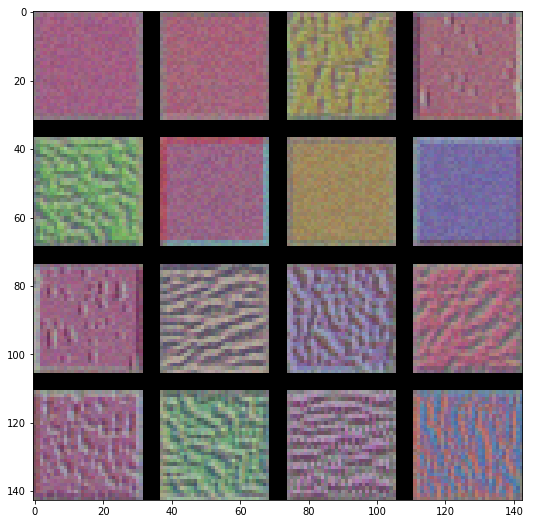

In [205]:
plt.figure(figsize=(16,9))
plt.imshow(stitched_filters)

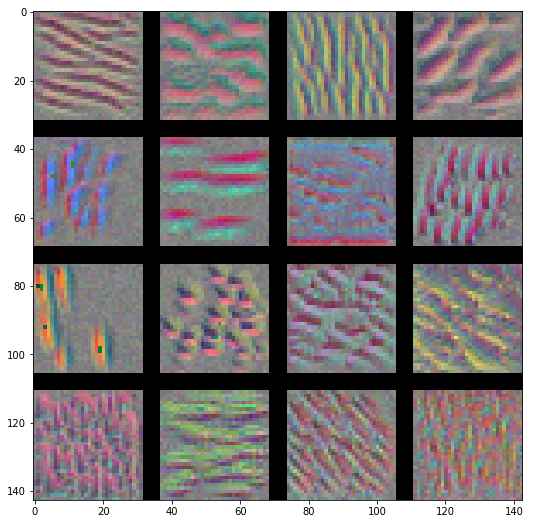

In [201]:
plt.figure(figsize=(16,9))
plt.imshow(stitched_filters)

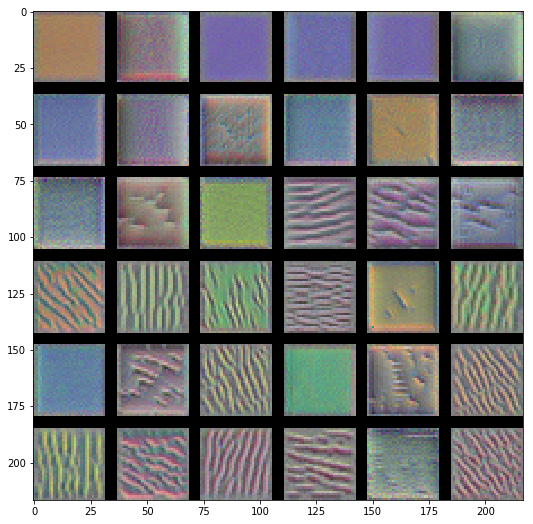

In [245]:
plt.figure(figsize=(16,9))
plt.imshow(stitched_filters)